# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Требуется построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.metrics import make_scorer, mean_squared_error

In [3]:
df_auto = pd.read_csv('/datasets/autos.csv')

df_auto.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 16 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        354369 non-null  object

 1   Price              354369 non-null  int64 

 2   VehicleType        316879 non-null  object

 3   RegistrationYear   354369 non-null  int64 

 4   Gearbox            334536 non-null  object

 5   Power              354369 non-null  int64 

 6   Model              334664 non-null  object

 7   Kilometer          354369 non-null  int64 

 8   RegistrationMonth  354369 non-null  int64 

 9   FuelType           321474 non-null  object

 10  Brand              354369 non-null  object

 11  Repaired           283215 non-null  object

 12  DateCreated        354369 non-null  object

 13  NumberOfPictures   354369 non-null  int64 

 14  PostalCode         354369 non-null  int64 

 15  LastSeen           354369 non-null  object

dtyp

In [4]:
df_auto.head(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
def rows_check(df_auto):
    for column in df_auto.columns:
        print('Уникальные значения столбца', column)
        print(df_auto[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(df_auto.isna().mean())

In [6]:
print(rows_check(df_auto))

Уникальные значения столбца DateCrawled

['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...

 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']

Уникальные значения столбца Price

[  480 18300  9800 ... 12395 18429 10985]

Уникальные значения столбца VehicleType

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения столбца RegistrationYear

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009

 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010

 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971

 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977

 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200

 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019

 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400

 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935

 193

Видя количество пропусков, нужно решить, удалить их или заменить на наиболее часто встречающееся значение. Если заменить все пропуски в столбце Vehicle Type - то мы потеряем около 10 процентов данных, что достаточно заметно. Поэтому, заменим пропущенные названия моделей автомобилей на самые распространенные в датафрейме.

In [8]:
df_auto['VehicleType'] = df_auto['VehicleType'].fillna('other')
df_auto["Gearbox"] = df_auto["Gearbox"].fillna('other')
df_auto["Model"] = df_auto["Model"].fillna('other')
df_auto["FuelType"] = df_auto["FuelType"].fillna('other')
df_auto["Repaired"] = df_auto["Repaired"].fillna('other')

Проверим данные на наличие дубликатов

In [9]:
df_auto.duplicated().sum()

4

In [10]:
df_auto = df_auto.drop_duplicates()
df_auto.duplicated().sum()

0

Удалим ненужные столбцы из датафрейма

In [11]:
df_with_date = df_auto.copy()
df_auto = df_auto.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

In [12]:
df_auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Займемся поиском аномалий. 

Видно, что в столбце Price - минимальное значение равно нулю.

Минимальное значение в столбце RegistrationYear - 1000й год, а максимальное - 9999.

Минимальное значение в столбце Power - 0 л.с., а максимальное - 20000. 

В столбце RegistrationMonth встречается значение "0". 

Столбцы индекса (PostalCode) и количества фотографий (NumberOfPictures) - не информативны, их можно удалить.

Ограничим значения в столбце RegistrationYear

In [13]:
def balance_RegistrationYear(value):
    if value > 2016:
        return 2016
    elif value < 1930:
        return 1930
    else:
        return value
df_auto["RegistrationYear"] = df_auto["RegistrationYear"].apply(balance_RegistrationYear)

Изменим нулевые значения в столбце RegistrationMonth

In [14]:
df_auto.loc[df_auto['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

Изменим аномальные значения столбца Power

count    354055.000000
mean        106.614676
std          64.206449
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max         999.000000
Name: Power, dtype: float64

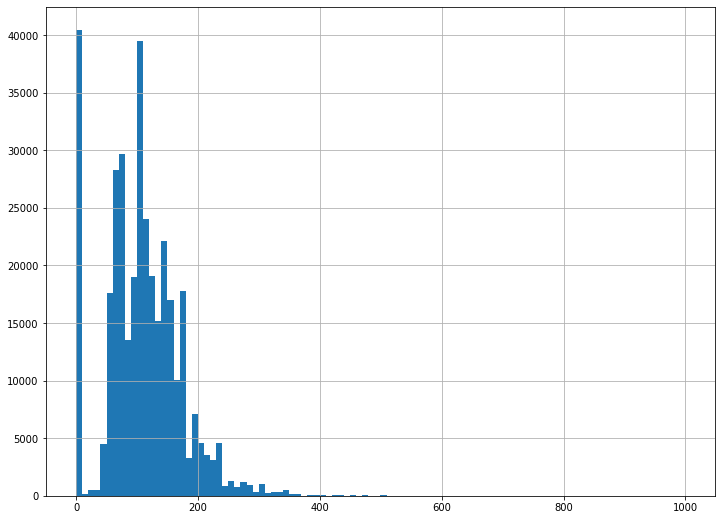

In [15]:
df_auto = df_auto.query('Power<1000')
df_auto['Power'].hist(bins=100, figsize=(12,9))
df_auto['Power'].describe()

count    312079.000000
mean        120.801932
std          54.538633
min          41.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

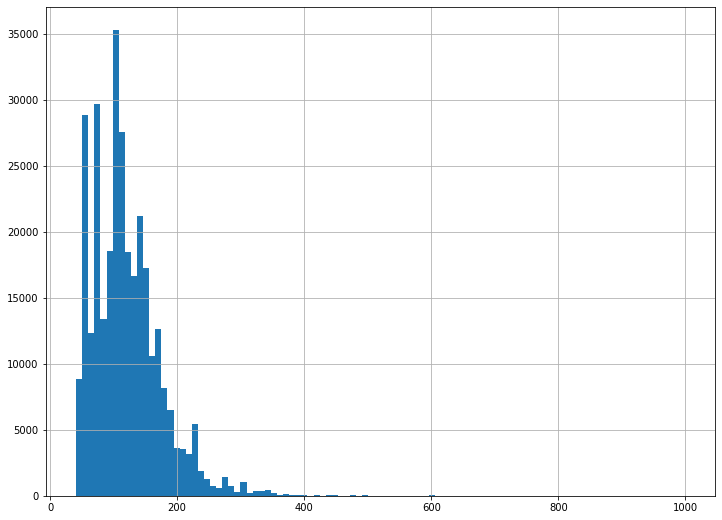

In [16]:
df_auto = df_auto.query('40<Power<1000')
df_auto['Power'].hist(bins=100, figsize=(12,9))
df_auto['Power'].describe()

Ограничим столбец Price

In [17]:
df_auto = df_auto.query('350 <= Price <= 8000')

In [18]:
#КОД РЕВЬЮЕРА

df_auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,233854.000000,233854.00000,233854.000000,233854.000000,233854.000000
mean,2978.676546,2002.31349,110.853071,134603.213971,6.008061
std,2109.514450,6.20078,45.846289,31020.498193,3.506289
min,350.000000,1930.00000,41.000000,5000.000000,1.000000
25%,1200.000000,1999.00000,75.000000,125000.000000,3.000000
50%,2400.000000,2002.00000,105.000000,150000.000000,6.000000
75%,4450.000000,2006.00000,136.000000,150000.000000,9.000000
max,8000.000000,2016.00000,999.000000,150000.000000,12.000000


## Обучение моделей

Разделим данные и закодируем выборки

In [22]:
#разделим выборки на обучающую и тестовую
target = df_auto['Price']
features = df_auto.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 


print(features_train.shape)
print(features_test.shape)

(175390, 10)

(58464, 10)


# Кодирование данных

In [23]:
from sklearn.preprocessing import OneHotEncoder

cat = list(features_train.select_dtypes('object').columns) #категориальные признаки
num = list(features_train.select_dtypes(exclude='object').columns) #количественные признаки

scaler = StandardScaler()

features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train[num]), columns=[num], index=features_train.index)
features_test_scaled = pd.DataFrame(scaler.transform(features_test[num]), columns=[num], index=features_test.index)

enc = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = enc.fit_transform(features_train[cat])
X_test_ohe = enc.transform(features_test[cat])

X_train_lr = pd.concat([features_train_scaled, pd.DataFrame(X_train_ohe.toarray(), index=features_train.index)], axis=1)
X_test_lr = pd.concat([features_test_scaled, pd.DataFrame(X_test_ohe.toarray(), index=features_test.index)], axis=1)

In [39]:
X_train_lr.head(5)

,"(RegistrationYear,)","(Power,)","(Kilometer,)","(RegistrationMonth,)",0,1,2,3,4,5,...,295,296,297,298,299,300,301,302,303,304
277177,-0.373820,-1.238602,0.496121,0.851658,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
279357,-0.051539,0.702791,0.496121,1.136659,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
299864,-1.662943,-1.238602,0.496121,1.136659,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
309444,-0.212680,-0.213372,0.496121,1.421661,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
273146,0.109601,0.855485,0.496121,1.421661,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Модель Linear Regression

In [27]:
%%time

model = LinearRegression()

#определяю RMSE модели с помощью кросс-валидации
regression_cv_score = (cross_val_score(model, X_train_lr, target_train,cv=5, 
                                                scoring='neg_root_mean_squared_error').mean()*-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

KeyboardInterrupt: 

# Модель решающего дерева

In [29]:
target = df_auto['Price']
features = df_auto.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 


print(features_train.shape)
print(features_test.shape)

(175390, 10)

(58464, 10)


In [30]:
df_auto.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

# Приступим к кодированию признаков

In [31]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='ignore')

cat_columns = ['VehicleType','FuelType','Brand','Model', 'Gearbox', 'Repaired']

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test[cat_columns])


InvalidParameterError: The 'handle_unknown' parameter of OrdinalEncoder must be a str among {'use_encoded_value', 'error'}. Got 'ignore' instead.

In [ ]:
features_train.shape

In [72]:
model =  DecisionTreeRegressor()
param_grid = {'max_depth': [3,6,9,12,15,18], 'random_state':[1234]}
testing_model=GridSearchCV(estimator=model,
                          param_grid = param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

testing_model.fit(features_train_oe, target_train)
display(testing_model.best_params_)
display(testing_model.best_score_*-1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits

[CV 1/3] END .................max_depth=3, random_state=1234; total time=   0.1s

[CV 2/3] END .................max_depth=3, random_state=1234; total time=   0.1s

[CV 3/3] END .................max_depth=3, random_state=1234; total time=   0.1s

[CV 1/3] END .................max_depth=6, random_state=1234; total time=   0.2s

[CV 2/3] END .................max_depth=6, random_state=1234; total time=   0.2s

[CV 3/3] END .................max_depth=6, random_state=1234; total time=   0.2s

[CV 1/3] END .................max_depth=9, random_state=1234; total time=   0.2s

[CV 2/3] END .................max_depth=9, random_state=1234; total time=   0.2s

[CV 3/3] END .................max_depth=9, random_state=1234; total time=   0.3s

[CV 1/3] END ................max_depth=12, random_state=1234; total time=   0.3s

[CV 2/3] END ................max_depth=12, random_state=1234; total time=   0.3s

[CV 3/3] END ................max_dept

{'max_depth': 12, 'random_state': 1234}

1127.2894045018536

# Модель случайного леса

In [75]:
model =  RandomForestRegressor()
param_grid = {'n_estimators': [100,500,1000], 'max_depth': [9],'random_state': [12345]}
testing_model=GridSearchCV(estimator=model,
                          param_grid = param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

testing_model.fit(features_train_oe, target_train)
display(testing_model.best_params_)
display(testing_model.best_score_*-1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits

[CV 1/3] END max_depth=9, n_estimators=100, random_state=12345; total time=  15.2s

[CV 2/3] END max_depth=9, n_estimators=100, random_state=12345; total time=  15.1s

[CV 3/3] END max_depth=9, n_estimators=100, random_state=12345; total time=  15.6s

[CV 1/3] END max_depth=9, n_estimators=500, random_state=12345; total time= 1.2min

[CV 2/3] END max_depth=9, n_estimators=500, random_state=12345; total time= 1.2min

[CV 3/3] END max_depth=9, n_estimators=500, random_state=12345; total time= 1.3min

[CV 1/3] END max_depth=9, n_estimators=1000, random_state=12345; total time= 2.5min

[CV 2/3] END max_depth=9, n_estimators=1000, random_state=12345; total time= 2.5min

[CV 3/3] END max_depth=9, n_estimators=1000, random_state=12345; total time= 2.5min


{'max_depth': 9, 'n_estimators': 500, 'random_state': 12345}

1126.1085642682933

# LightGBM

In [76]:
!pip install lightgbm
import lightgbm
print(lightgbm.__version__)


target = df_auto['Price']
features = df_auto.drop('Price', axis=1)

# переведем категориальные признаки в тип category
for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object':
        features[c] = features[c].astype('category')

#разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 

# проверим размер выборок
print(features_train.shape)
print(features_test.shape)








3.3.1

(175390, 10)

(58464, 10)


In [78]:
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 20)]}

In [89]:
model = lgb.LGBMRegressor(random_state=12345)

testing_model=GridSearchCV(estimator=model,
                          param_grid = param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

testing_model.fit(features_train, target_train)
display(testing_model.best_params_)
display(testing_model.best_score_*-1)

Fitting 3 folds for each of 42 candidates, totalling 126 fits

[CV 1/3] END ................n_estimators=100, num_leaves=20; total time=   4.0s

[CV 2/3] END ................n_estimators=100, num_leaves=20; total time=   4.1s

[CV 3/3] END ................n_estimators=100, num_leaves=20; total time=   4.8s

[CV 1/3] END ................n_estimators=100, num_leaves=40; total time=   4.7s

[CV 2/3] END ................n_estimators=100, num_leaves=40; total time=   5.0s

[CV 3/3] END ................n_estimators=100, num_leaves=40; total time=   4.7s

[CV 1/3] END ................n_estimators=100, num_leaves=60; total time=   6.3s

[CV 2/3] END ................n_estimators=100, num_leaves=60; total time=   5.8s

[CV 3/3] END ................n_estimators=100, num_leaves=60; total time=   5.8s

[CV 1/3] END ................n_estimators=100, num_leaves=80; total time=   7.3s

[CV 2/3] END ................n_estimators=100, num_leaves=80; total time=   7.6s

[CV 3/3] END ................n_esti

{'n_estimators': 500, 'num_leaves': 160}

931.8355125358025

# Итог второго этапа

Были обучены модели линейной регрессии, решающего дерева, случайного леса и LGBM. Лучшие гиперпараметры для LGBM: 'n_estimators' = 500, 'num_leaves' = 160 , дает RMSE = 931.835

## Анализ моделей

# Модель линейной регрессии


In [90]:
%%time

# найдем время обучения модели линейной регрессии
model = LinearRegression()
model.fit(X_train_ohe, target_train)

CPU times: user 10 s, sys: 8.43 s, total: 18.5 s

Wall time: 18.6 s


LinearRegression()

In [91]:
%%time

#построим предсказания на тренировочной выборке и найдем скорость

predictions_train_ohe = model.predict(X_train_ohe)

CPU times: user 15.1 ms, sys: 16.8 ms, total: 31.9 ms

Wall time: 4.35 ms


# Модель решающего дерева

In [92]:
%%time

# найдем время обучения модели решающего дерева
model = DecisionTreeRegressor(random_state=1234, max_depth=12)
model.fit(features_train_oe, target_train)

CPU times: user 377 ms, sys: 0 ns, total: 377 ms

Wall time: 375 ms


DecisionTreeRegressor(max_depth=12, random_state=1234)

In [93]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train_oe = model.predict(features_train_oe)

CPU times: user 28.1 ms, sys: 0 ns, total: 28.1 ms

Wall time: 26.1 ms


# Модель случайного леса

In [94]:
%%time

# обучим модель случайного леса
model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=500)
model.fit(features_train_oe, target_train)

CPU times: user 1min 43s, sys: 122 ms, total: 1min 43s

Wall time: 1min 44s


RandomForestRegressor(max_depth=9, n_estimators=500, random_state=12345)

In [95]:
%%time
#построим предсказания на тренировочной выборке
predictions_train_oe = model.predict(features_train_oe)

CPU times: user 5.98 s, sys: 0 ns, total: 5.98 s

Wall time: 5.99 s


# Модель LightGBM

In [96]:
%%time
# найдем время обучения LightGBM

model = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=160)
model.fit(features_train, target_train)

CPU times: user 42.4 s, sys: 167 ms, total: 42.6 s

Wall time: 43.2 s


LGBMRegressor(n_estimators=500, num_leaves=160, random_state=12345)

In [97]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train = model.predict(features_train)

CPU times: user 20.1 s, sys: 6.04 ms, total: 20.1 s

Wall time: 20.1 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

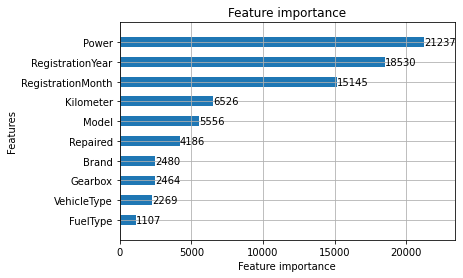

In [99]:
lgb.plot_importance(model, height=.5)

# Таблица времени обучения и предсказания

In [100]:
tabledata = [["Линейная регрессия: обучение", "18,5 s", "18,6 s"],
             ["Линейная регрессия: предсказание", "31,9 ms", "435 ms"],
         ["Решающее дерево: обучение", "377 ms", " 375 ms"],
         ["Решающее дерево: предсказание", "28,1 ms", "26,1 ms"],
         ["Случайный лес: обучение", "1 min 43s", "1 min 44s"],
         ["Случайный лес: предсказание", "5,98 s", "5,99 s"],
         ["LightGBM: обучение", "42,6 s", "43,2 s"],
         ["LightGBM: предсказание", "20,1 s", "20,1 s"]]
df_table= pd.DataFrame(tabledata, columns=["модель","CPU-times", "Wall time"])
df_table = df_table.set_index('модель')
df_table.index.names = [None]
display(df_table)

,CPU-times,Wall time
Линейная регрессия: обучение,"18,5 s","18,6 s"
Линейная регрессия: предсказание,"31,9 ms",435 ms
Решающее дерево: обучение,377 ms,375 ms
Решающее дерево: предсказание,"28,1 ms","26,1 ms"
Случайный лес: обучение,1 min 43s,1 min 44s
Случайный лес: предсказание,"5,98 s","5,99 s"
LightGBM: обучение,"42,6 s","43,2 s"
LightGBM: предсказание,"20,1 s","20,1 s"


In [104]:
tabledata = [["Линейная регрессия: RMSE", "55862078329.03"],
         ["Решающее дерево: RMSE", "1127.28"],
         ["Случайный лес: RMSE", "1126.10"],
         ["LightGBM: RMSE", "919.38"]]


df_table= pd.DataFrame(tabledata, columns=["модель","RMSE"])
df_table = df_table.set_index('модель')
df_table.index.names = [None]
display(df_table)

,RMSE
Линейная регрессия: RMSE,55862078329.03
Решающее дерево: RMSE,1127.28
Случайный лес: RMSE,1126.10
LightGBM: RMSE,919.38


# Проверка лучшей модели на тестовой выборке

In [103]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print(rmse)

919.3880024084755


# Вывод по этапу 3


Самое долгое время обучения - у модели случайного леса. Модель LightGBM имеет подходящую скорость обучения и предсказания, около 40 секунд на обучение и около 20 секунд на предсказание. При этой скорости данная модель также показывает RMSE = 919.38. 

# Общий вывод

1) В первую очередь мы ознакомились с данными, обработали пропуски, удалили неинформативные столбцы и избавились от дубликатов и аномалий.


2) На данном этапе мы закодировали данные и сравнили эффективность различных моделей. Обучили разные модели, подобрали гиперпараметры для них, выяснилось, что лучшие гиперпараметры для LGBM: 'n_estimators' = 500, 'num_leaves' = 160 , дает RMSE = 919.38. 


3) В заключительном этапе мы провели сравнение в времени обучения всех используемых моделей. Самое долгое время обучения - у модели случайного леса. Модель LightGBM имеет подходящую скорость обучения и предсказания, около 40 секунд на обучение и около 20 секунд на предсказание. При этой скорости данная модель также показывает RMSE = 919.38. 